In [26]:
# Import data source
from zipfile import ZipFile
file_name = "emojify.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


In [ ]:

import numpy as np
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

<h2>Importing Data</h2>

In [12]:
train_dir = 'train'
val_dir = 'test'
train_datagen = ImageDataGenerator(
        rotation_range=30,## data augmentation, able to increase the accuracy of the training.
        zoom_range=0.2,
        rescale=1./255,
        fill_mode='nearest') # Split 0.2 of the train data to validation data
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 25269 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


<h2>Defining the Model</h2>

In [ ]:
emotion_model = Sequential()
emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))
emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.25))
emotion_model.add(Dense(6, activation='softmax'))

<h3>F1 Score: a method for evaluating the accuracy of a model</h3>
The block below should be runned before loading the model.

In [4]:
import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

<h3>Training the Model</h3>
The accuracy of my model is around 60% only. The accuracy can be slightly improved by training with 200 iterations. Use Google Colab with a GPU to speed up the training to around 10~12s per epoch.
Note that the accuracy of the model for random guessing is 16.67% (1/6); While the accuracy for a binary classification model for random guessing is 50% (1/2), so the accuracies of binary classification model and this kind of model cannot be compared directly.

In [ ]:
emotion_model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001, decay=1e-6),
      metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),f1_score])
emotion_model_info = emotion_model.fit(
        train_generator,
        steps_per_epoch=12000 // 64,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=7000 // 64)

Epoch 1/50
187/187 [==============================] - 28s 83ms/step - loss: 1.7742 - accuracy: 0.1992 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5576 - f1_score: 0.0000e+00 - val_loss: 1.7497 - val_accuracy: 0.2169 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5936 - val_f1_score: 0.0000e+00
Epoch 2/50
187/187 [==============================] - 17s 91ms/step - loss: 1.7254 - accuracy: 0.2523 - precision: 0.5479 - recall: 0.0067 - auc: 0.6195 - f1_score: 0.0128 - val_loss: 1.6506 - val_accuracy: 0.3023 - val_precision: 0.6579 - val_recall: 0.0215 - val_auc: 0.6764 - val_f1_score: 0.0413
Epoch 3/50
187/187 [==============================] - 15s 81ms/step - loss: 1.6777 - accuracy: 0.2899 - precision: 0.6324 - recall: 0.0258 - auc: 0.6545 - f1_score: 0.0486 - val_loss: 1.6191 - val_accuracy: 0.3122 - val_precision: 0.6752 - val_recall: 0.0453 - val_auc: 0.6884 - val_f1_score: 0.0839
Epoch 4/50
187/187 [==============================] - 15s 81ms/step - loss: 

<h2>Saving the Model</h2>

In [ ]:
#Saving the model
emotion_model.save('model.h5')

<h2>Loading the Model</h2>
Loading the model named "model.h5". If you don't have enough time to train, just use the file I gave.
The accuracy of my model is around 60% only. The accuracy can be slightly improved by training with 200 iterations.

In [5]:
from keras.models import load_model
emotion_model = load_model('model.h5',custom_objects={'f1_score':f1_score})

<h2>Live Identifying Emotions</h2>
(Not very accurate, maybe due to the third-party face detection algorithm), 有時候認唔到人<br>
建議 open in PyCharm (唔好 open in Google Colab, 會 run 唔到 ; - ;)

In [8]:
import cv2
import numpy as np


emotion_dict = {0: "Angry",  1: "Fearful", 2: "Happy", 3: "Neutral", 4: "Sad", 5: "Surprised"}


# start the webcam feed
#cap = cv2.VideoCapture(0)

# pass here your video path
# you may download one from here : https://www.pexels.com/video/three-girls-laughing-5273028/
cap = cv2.VideoCapture("pexels-gabby-k-5273028.mp4")

while True:
    # Find haar cascade to draw bounding box around face
    ret, frame = cap.read()
    frame = cv2.resize(frame, (1280, 720))
    if not ret:
        break
    face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # detect faces available on camera
    num_faces = face_detector.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)

    # take each face available on the camera and Preprocess it
    for (x, y, w, h) in num_faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (0, 255, 0), 4)
        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)

        # predict the emotions
        emotion_prediction = emotion_model.predict(cropped_img)
        maxindex = int(np.argmax(emotion_prediction))
        cv2.putText(frame, emotion_dict[maxindex], (x+5, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    cv2.imshow('Emotion Detection',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

<h2>Confusion Matrix</h2>

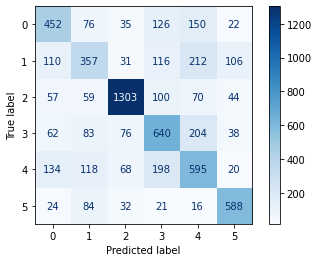

[[ 452   76   35  126  150   22]
 [ 110  357   31  116  212  106]
 [  57   59 1303  100   70   44]
 [  62   83   76  640  204   38]
 [ 134  118   68  198  595   20]
 [  24   84   32   21   16  588]]


In [17]:
import tensorflow as tf
import numpy as np
from keras.models import model_from_json
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay


emotion_dict = {0: "Angry", 1: "Fear", 2: "Happy", 3: "Neutral", 4: "Sad", 5: "Surprised"}

# do prediction on test data


predictions = np.array([])
labels =  np.array([])

I = 0
for x, y in validation_generator:
  predictions = np.concatenate([predictions, np.argmax(emotion_model.predict(x),axis=-1)])
  labels = np.concatenate([labels, np.argmax(y,axis=-1)])
  I += 1
  if I > 100:
    break
ConfusionMatrixDisplay(
    confusion_matrix=tf.math.confusion_matrix(
        labels=labels, predictions=predictions)
    .numpy(), display_labels=emotion_dict).plot(cmap=plt.cm.Blues)
plt.show()
print(tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy())

In [18]:
# Classification report
print("-----------------------------------------------------------------")
print(classification_report(labels, predictions))

-----------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.54      0.52      0.53       861
         1.0       0.46      0.38      0.42       932
         2.0       0.84      0.80      0.82      1633
         3.0       0.53      0.58      0.56      1103
         4.0       0.48      0.53      0.50      1133
         5.0       0.72      0.77      0.74       765

    accuracy                           0.61      6427
   macro avg       0.60      0.60      0.59      6427
weighted avg       0.61      0.61      0.61      6427



<h2>Photo Emotion Analysis</h2>

In [6]:
def emotion_analysis(emotions):
    objects = ('Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

<h3>Capturing Image using Laptop Camera in Google Colab</h3>

In [ ]:
#CODE for Capturing an image on Colab from here: https://colab.research.google.com/notebook#fileId=1OnUy6eFE7XhdfGfAHDCqQxpwueTOj_NO

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
take_photo()

<h3>Defining the Face-cropping Algorithm (third-party)</h3>


Writing: fear.jpg


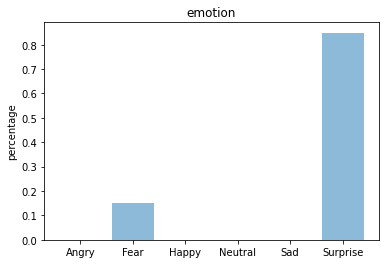

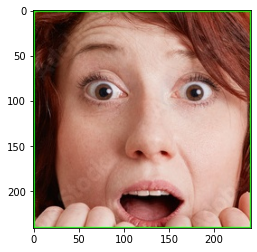

In [7]:
import cv2
            
def facecrop(image):  
    facedata = cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml'
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)

    try:
    
        minisize = (img.shape[1],img.shape[0])
        miniframe = cv2.resize(img, minisize)

        faces = cascade.detectMultiScale(miniframe)

        for f in faces:
            x, y, w, h = [ v for v in f ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            sub_face = img[y:y+h, x:x+w]

            
            cv2.imwrite('capture.jpg', sub_face)
            print ("Writing: " + image)

    except Exception as e:
        print (e)

   


if __name__ == '__main__':
    facecrop('fear.jpg') ###############the file path here is your image

#Testing a file.

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


file = 'capture.jpg'
true_image = image.load_img(file)
img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = emotion_model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48])


plt.imshow(true_image)
plt.show()